# Comparison of our method to VAEs on 2D gridworld

Here, we show that two benchmark methods for learning representations: CCI-VAEs and hyperspherical VAEs, both fail to learn the structure underlying the periodic gridworld that we study in our work. This is because these methods learn structure from observational data, which here has no clear structure.

### 1) Load libraries

In [1]:
import os

import math
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
import time

from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

from tqdm import tqdm

Set seaborn plotting defaults.


/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

### 2) Create static dataset from gridworld interaction data

We will use a static dataset for all of these experiments. We start by defining the environment

In [2]:
class GridWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,dim=10):

        self.dim = dim

        self.action_space = self.action_space(4)
        self.observation_space = self.observation_space(dim**2)
        
        self.reset()
        
    def reset(self):
        self.ball_coordinates = [random.randrange(self.dim), random.randrange(self.dim)]
        self.state = self.get_state()
        return self.get_observation()
    
    def get_state(self, ball_coordinates=None):
        if ball_coordinates is None:
            ball_coordinates=self.ball_coordinates
            
        state = torch.zeros((self.dim,self.dim))
        state[ball_coordinates[0],ball_coordinates[1]] = 1
        
        return state
    
    def get_observation(self):
        return self.state.flatten()
    
    def step(self,action):

        if action == 0:
            self.ball_coordinates[0] = (self.ball_coordinates[0] + 1)%self.dim
        elif action == 1:
            self.ball_coordinates[0] = (self.ball_coordinates[0] - 1)%self.dim
        elif action == 2:
            self.ball_coordinates[1] = (self.ball_coordinates[1] + 1)%self.dim
        elif action == 3:
            self.ball_coordinates[1] = (self.ball_coordinates[1] - 1)%self.dim
        else:
            raise Exception("Invalid action.")

        self.state = self.get_state()

        return self.get_observation()

Now we show a few consecutive states from this gridworld

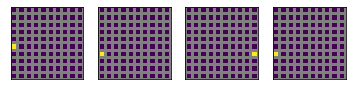

In [3]:
def plot_state(state, ax):
    ax.pcolormesh(state, edgecolors='gray', linewidth=2, )
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 3

env = GridWorld()

fig, axs = plt.subplots(1, n_steps+1,)

plot_state(env.state,axs[0])

for i in range(n_steps):
    env.step(np.random.randint(0,4))
    plot_state(env.state,axs[i+1])

We now color code the different positions on this grid, which will be used when studying the representations learned by the different benchmarks

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


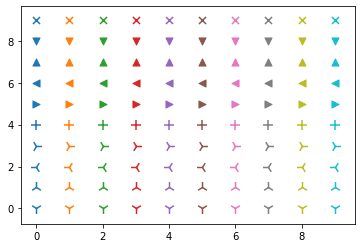

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]

s=[120]*5+[50]*6

for i in range (100):
    ax.scatter(x=i//10,
                y=i%10,
   #             zs=latent_2d.transpose()[2][i],
                c=color[i//10], 
                s=s[i%10],
                marker=marks[i%10])

fig.show()


We now actually create a dataset containing states from this environment

In [5]:
N_DATA = 10000

dataset = {}
env = GridWorld()
for i in range(N_DATA):
    state = env.step(np.random.randint(0,4))
    dataset[i] = state

# Representations learned by a CCI-VAE

The representations learned by the autoencoder are all over the place; let's see how a VAE fares.

### 1) Define and train VAE

The following code derives from the pytorch repo on github https://github.com/pytorch/examples/blob/master/vae/main.py

In [10]:
device = torch.device("cpu")

def init_weights(m, gain):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d):
        nn.init.orthogonal_(m.weight, gain)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class VAE(nn.Module):
    def __init__(self, latent_dim = 4, weight_scale=3, final_capacity=25, final_capacity_step=10000):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc31 = nn.Linear(64, latent_dim)
        self.fc32 = nn.Linear(64, latent_dim)
        self.fc4 = nn.Linear(latent_dim, 64)
        self.fc5 = nn.Linear(64, 256)
        self.fc6 = nn.Linear(256, 100)
        
        self.final_capacity = final_capacity
        self.final_capacity_step = final_capacity_step
        self.capacity = 0
        self.step = 0
        
        init_weights(self.fc1, weight_scale)
        init_weights(self.fc2, weight_scale)
        init_weights(self.fc31, weight_scale)
        init_weights(self.fc32, weight_scale)
        init_weights(self.fc4, weight_scale)
        init_weights(self.fc5, weight_scale)
        init_weights(self.fc6, weight_scale)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        return torch.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def update_capacity(self):
        if self.step < self.final_capacity_step:
            self.capacity += self.final_capacity/self.final_capacity_step
        self.step += 1
        return self.capacity
    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar,beta, capacity):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta*torch.abs(KLD-capacity)


In [11]:
LR = 1e-3
N_STEPS = 10000
BATCH_SIZE = 32
BETA = 1
LATENT_DIM = 4
FINAL_CAPACITY = 1
FINAL_CAPACITY_STEP = 5000

vae = VAE(latent_dim = LATENT_DIM)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR, weight_decay=0)

losses = []
for i in tqdm(range(N_STEPS)):
    
    batch = torch.stack(random.sample(list(dataset.values()), BATCH_SIZE))
    recon_batch, mu, logvar = vae(batch)
    capacity = vae.update_capacity()
    loss = loss_function(recon_batch, batch, mu, logvar, BETA, capacity)
    
    losses.append(loss.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Loss on last batch was {}".format(loss.detach()))

100%|██████████| 10000/10000 [00:56<00:00, 178.35it/s]

Loss on last batch was 56.27629089355469


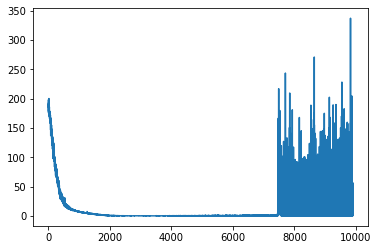

In [12]:
plt.plot(losses[100:])

### 2) Check that the VAE correctly reconstructs the state


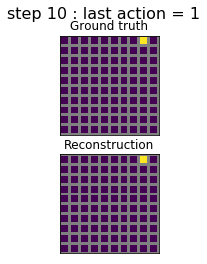

In [13]:
def plot_state(obs, ax):
    ax.pcolormesh(obs.reshape(env.dim, env.dim), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = env.reset()
    else:
        action = env.action_space.sample().item()
        obs_x = env.step(action)
        
    obs_z, _ = vae.encode(env.state.flatten())
    obs_x_recon = vae.decode(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    fig_fname = "_data/testing_{}".format(i)
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

### 3) Inspect learned representations

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


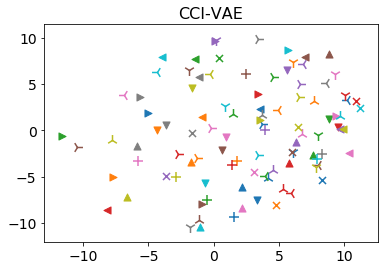

In [14]:
num_frames = sum(env.observation_space.shape)

latent_points = []

for i in range(num_frames):
    frame = torch.zeros(num_frames)
    frame[i] = 1
    latent,var = vae.encode(frame)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)
pca = GaussianRandomProjection(n_components=2)

if LATENT_DIM == 2:
    latent_2d = latent_map
else: 
    latent_2d = pca.fit_transform(latent_map)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (100):
    ax.scatter(x=latent_2d.transpose()[0][i],
                y=latent_2d.transpose()[1][i],
             #   zs=latent_2d.transpose()[2][i],
                c=color[i//10], 
                s=s[i%10],
                marker=marks[i%10])
 #   ax.set_xlim(-.6/1.4,.6/1.4)
  #  ax.set_ylim(-.8/1.4,.8/1.4)
  #  ax.set_zlim(-1./1.6,1./1.6)
    #ax.view_init(elev=45, azim=45)
plt.title('CCI-VAE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("ccivae.png", bbox_inches='tight')

# Representations learned by a hyperspherical VAE

The VAE does place the representations roughly within a centered blob, but no structure is apparent. Perhaps a more structured latent space would be helpful? We now turn to hyperspherical VAEs, which use a spherical latent space as in our work.

### 1) Define and train hyperspherical VAE

The following code derives from the pytorch repo on github https://github.com/nicola-decao/s-vae-pytorch

In [15]:
from src.hyperspherical_utils import VonMisesFisher
from src.hyperspherical_utils import HypersphericalUniform

In [16]:
class HVAE(torch.nn.Module):
    
    def __init__(self, latent_dim=4, activation=F.relu, distribution='normal'):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param latent_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(HVAE, self).__init__()
        
        self.latent_dim, self.activation, self.distribution = latent_dim, activation, distribution
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(100, 256)
        self.fc_e1 = nn.Linear(256, 64)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(64, latent_dim)
            self.fc_var =  nn.Linear(64, latent_dim)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(64, latent_dim)
            self.fc_var = nn.Linear(64, 1)
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(latent_dim, 64)
        self.fc_d1 = nn.Linear(64, 256)
        self.fc_logits = nn.Linear(256, 100)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.latent_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_
    

In [17]:
LR = 1e-3
N_STEPS = 5000
BATCH_SIZE = 32
LATENT_DIM = 4
DISTRIBUTION = 'vmf'

hvae = HVAE(latent_dim = LATENT_DIM, distribution = DISTRIBUTION)
optimizer = torch.optim.Adam(hvae.parameters(), lr=LR, weight_decay=0)

for i in tqdm(range(N_STEPS)):
    
    batch = torch.stack(random.sample(list(dataset.values()), BATCH_SIZE))
    
    _, (q_z, p_z), _, recon_batch = hvae(batch)
    loss_recon = nn.BCEWithLogitsLoss(reduction='sum')(recon_batch, batch)
    
    if hvae.distribution == 'normal':
        loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
    elif hvae.distribution == 'vmf':
        loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
    else:
        raise NotImplemented

    loss = loss_recon + loss_KL 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Loss on last batch was {}".format(loss.detach()))

100%|██████████| 5000/5000 [00:57<00:00, 87.54it/s] 

Loss on last batch was 7.250359535217285


### 2) Check that the HVAE correctly reconstructs the state

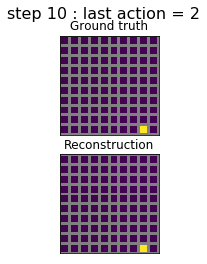

In [18]:
def plot_state(obs, ax):
    ax.pcolormesh(obs.reshape(env.dim, env.dim), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = env.reset()
    else:
        action = env.action_space.sample().item()
        obs_x = env.step(action)
        
    _, (q_z, p_z), _, obs_x_recon = hvae(env.state.flatten())
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(F.softmax(obs_x_recon.detach(),dim=0).numpy(),ax2)
    
    fig_fname = "_data/testing_{}".format(i)
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

### 3) Inspect learned representations

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


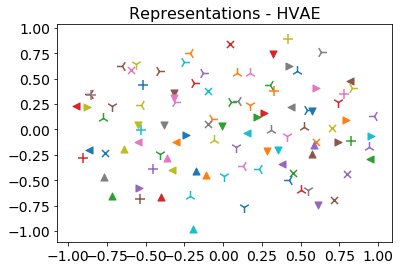

In [19]:
num_frames = sum(env.observation_space.shape)

latent_points = []

for i in range(num_frames):
    frame = torch.zeros(num_frames)
    frame[i] = 1
    latent,_ = hvae.encode(frame)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)
    
least_important_dim = latent_map.std(axis=0).argmin()
axes_to_select = []
for i in range(LATENT_DIM):
    if i != least_important_dim:
        axes_to_select.append(i)
latent_map = latent_map[:,axes_to_select]
                        
latitudes = np.pi/2-np.arccos(latent_map[:,2])
longitudes = np.arctan2(latent_map[:,0],latent_map[:,1])
new_z = np.sqrt(1+np.cos(latitudes)*np.cos(longitudes/2))
new_x = np.cos(latitudes) * np.sin(longitudes/2) / new_z
new_y = np.sin(latitudes) / new_z

period = 10

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
for i in range (period**2):
    ax.scatter(new_x[i],new_y[i],
                c=color[i//period], 
                s=s[i%period],
                marker=marks[i%period])
plt.title('Representations - HVAE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("hvae.png", bbox_inches='tight')